In [1]:
# loading a dataset from pytorch
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms.functional
from torch import nn

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# simply call dataset
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.MNIST(
    root = 'data',
    train=False,
    download=True,
    transform=transform
)

print(len(train_data))
# B, Type, Tensor

60000


In [2]:
# from make_latents import store_latents
# import os
# model_stupd = lambda x: x
# store_latents(test_data,"latent_expiriment",model_stupd)

# img = torch.load(os.path.join("latent_expiriment","latent_storage.pt"))
# print(img[0][4])

torch.Size([28, 28])


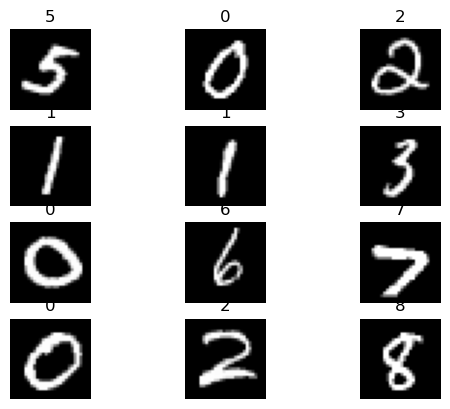

In [3]:
# visualizing data
t = train_data[3000][0].squeeze()
fig,axes = plt.subplots(4,3)




for i in range(12):
    ind = torch.randint(low=0,high=len(train_data),size=(1,)).item()
    img,label = train_data[ind]
    axes[i // 3][i % 3].imshow(img.squeeze(),cmap='grey')
    axes[i // 3][i % 3].axis("off")
    axes[i // 3][i % 3].set_title(label)


print(t.shape)
    
    


In [4]:
'''Training a neural net.

Now, we can use the useful batch function to train
our neural network to classify digits!
'''
from torch.utils.data import DataLoader
device = 'cuda'

# simple convolutional neural network
class CNN(nn.Module):
    def __init__(self,channels,im_dims,n_labels,hidden_size=200,device=device):
        super().__init__()
        # define channels, do conv net
        # accordingly
        self.layers = nn.ModuleList()
        
        for i in range(len(channels)-1):
            self.layers.append(nn.Conv2d(channels[i],channels[i+1],kernel_size=3,padding=1,device=device))
            self.layers.append(nn.ReLU())
        
        self.final_conv = nn.Conv2d(channels[-1],channels[0],kernel_size=1,padding=0)
        
        self.mlp = nn.Sequential(
            nn.Linear(im_dims[0]*im_dims[1]*channels[0],hidden_size,device=device),
            nn.GELU(approximate='tanh'),
            nn.Linear(hidden_size,n_labels,device=device)
        )
        
    def forward(self,x):
        
        for layer in self.layers:
            x = layer(x)
        x = self.final_conv(x)
        # B, C, H, W -> B,C*H*W
        x = x.view(x.shape[0],-1)
        x = self.mlp(x)
        
        # softmax
        # B,labels
        x = nn.functional.softmax(x,dim=-1)
        return x
    
    
model = CNN([1,3,6,3],[28,28],10)
model.to(device)
model.train()

# loss criterion, dataloader, optimizer
train_loader = DataLoader(train_data,128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
epochs = 1


In [5]:
for i in range(epochs):
    print("Epoch:",i)
    running_loss = 0
    for batch in train_loader:
        # batch is image and label
        img,label = batch
        img,label = img.to(device),label.to(device)
        output = model(img)
        
        
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss
    print("Epoch-Loss:",running_loss)
    
    

Epoch: 0
Epoch-Loss: tensor(871.5022, device='cuda:0', grad_fn=<AddBackward0>)


In [6]:
# testing model output
# visualizing data
t = train_data[3000][0].squeeze()




for i in range(12):
    ind = torch.randint(low=0,high=len(test_data),size=(1,)).item()
    img,label = test_data[ind]
    print("Model-Assigned: ",model(img.to(device))[0][label])
    
    
# we have a model that can classify digits now.

Model-Assigned:  tensor(0.8874, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(0.0008, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(0.8994, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(3.6619e-08, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(0.9979, device='cuda:0', grad_fn=<SelectBackward0>)


In [7]:
 
'''Custom Dataset

1. Provide length and get_item, so torch can get batches,
and we can access it like a normal dataset

2. Init function, where we intialize the folder with the 
labels and their connected images

The dataloader we'll use is not going to use
labels at all.
'''

from dataloader import raw_images_convert
from dataloader import save_raw_labels
# downloading data
train_data = torchvision.datasets.CIFAR10(
    root = 'data',
    train = True,
    download=True
)

raw_images_convert(train_data,'hello','jpg',100)
save_raw_labels(train_data,'label_folder',100)




Files already downloaded and verified


50000it [00:00, 62096.59it/s]

Saved  99  images in  hello
saved at  label_folder\labels.csv


torch.Size([3, 32, 32])
None


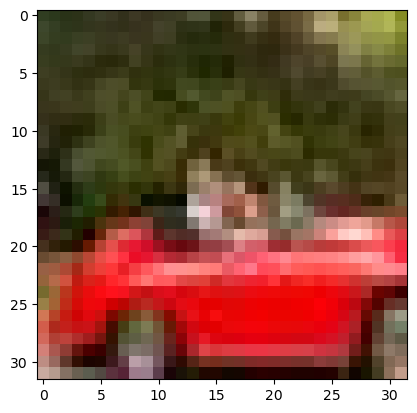

In [8]:
from dataloader import ImageDataset
# now, should be able to use with batches!

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([32,32]),
    torchvision.transforms.ToTensor()
])

# should load images from given path!
dataset = ImageDataset(transform,'hello')

print(dataset[80][0].shape)
print(dataset[81][1]) # no-label!
plt.imshow(dataset[99][0].permute(1,2,0))

In [ ]:
# testing latent-storage
from make_latents import store_latents
from dataloader import save_raw_labels

model_identity = lambda x: x

print(len(dataset))

# store latents after we've created the dataset usually.
store_latents(dataset,'latent_folder',model_identity)

100


100%|██████████| 100/100 [00:00<00:00, 297.07it/s]


None 6


c:\Users\charl\OneDrive\Machine Learning\ResearchCyclePipe\dataloader.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  imgs_file = torch.load(full_path)
c:\Users\charl\

Text(0.5, 1.0, 'Label: None')

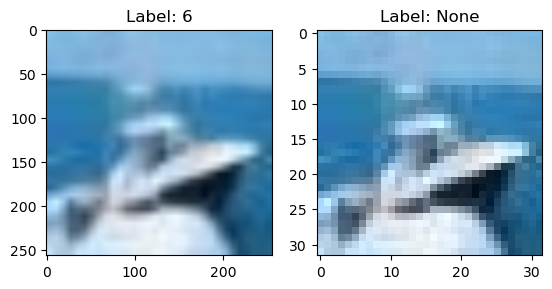

In [ ]:
from dataloader import ImageDataset

# testing whether our latents worked
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    torchvision.transforms.ToTensor()
])

# now, loading both types of data
# to see if our latent-storer worked!
dataset1 = ImageDataset(transform,'hello',im_extension='jpg',use_latents=False,label_folder='label_folder')
dataset2 = ImageDataset(transform,'hello',None,'jpg',True,'latent_folder')

fig,axes = plt.subplots(1,2)

print(dataset2[0][1],dataset1[0][1])
axes[0].imshow(dataset1[8][0].permute(1,2,0))
axes[1].imshow(dataset2[8][0].permute(1,2,0))


axes[0].set_title(f"Label: {dataset1[0][1]}")
axes[1].set_title(f"Label: {dataset2[0][1]}")

# 2nd has a transform, 1st is raw... (bc latent)



##### Yay! We are now able to save latents, and use any images we want (we can even collect them ourselves :() )

- Now we're able to save and use labels as well!

Heres how we should use this:

1. Download torchvision dataset (or your own!)
2. Save labels and images into csv and raw format
3. Create custom dataset
4. Create latents based on this with your dataset and VAE

And use our custom-dataset!